Edge Detector from Assigmnet 3 - Question 2.<br>
Shape Detector from Assigmnet 3 - Question 2.

In [1]:
# Imports
import cv2
import math
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy import signal
import itertools

def zipAll(arr1, arr2):
    return list(itertools.product(arr1, arr2))

figsize = (15, 5)

# Print the full NumPy array
import sys
np.set_printoptions(threshold=sys.maxsize)

Text(0.5, 1.0, 'Original')

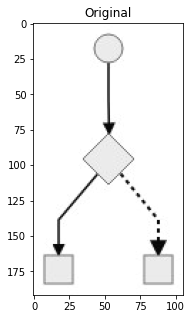

In [ ]:
# Load the images in grayscale
#path = "justCircle.png" # 100r
#path = "justCircleSmaller.png" # 50r
#path = "justCircleSmallerSide.png" # 50r
#path = "justCircles.png"
#path = "justCircleInside.png" # 29r 61r
#path = "justCircleInsideCenter.png" # 29r 61r
#path = "justRad.png" # 61r
##########path  = "justRectSmall.png"
path = "Digital_all_labels.jpg"
#path = "justRectangle.png"
#path = "rects_circles.png"
#path = "rects_circles_bigger.png" # unrunnable, takes more than 20min
#path = "rects_circles_medium.png"
#path = "why.png"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# Resize img to smaller size (while keeping the same scale)
max_img_size = 200
y_max, x_max = img.shape
if y_max >= x_max:
    if y_max > max_img_size:
        scale = max_img_size / y_max
        width = int(x_max * scale)
        height = max_img_size # int(y_max * scale)
        dim = (width, height)
        img = cv2.resize(img, dim)
else:
    if x_max > max_img_size:
        scale = max_img_size / x_max
        width = max_img_size # int(x_max * scale)
        height = int(y_max * scale)
        dim = (width, height)
        img = cv2.resize(img, dim)


# Display image
_, ax = plt.subplots(1, 1, figsize=figsize)
ax.imshow(img, cmap='gray')
ax.set_title("Original")

In [ ]:
# Blur the image
blur_image = False

if blur_image:
    blur = cv2.blur(img, (5,5))
    
    # Display image
    _, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(blur, cmap='gray')
    ax.set_title("Blur")
else:
    blur = np.copy(img)

In [ ]:
# Sharpen the image
sharp_image = False

if sharp_image:
    sharp_kernel = np.array([
        [-1, -1, -1],
        [-1,  9, -1],
        [-1, -1, -1],
    ])
    sharp = cv2.filter2D(blur, ddepth=cv2.CV_64F, kernel=sharp_kernel).astype(np.float)

    # Display image
    _, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(sharp, cmap='gray')
    ax.set_title("Sharp")
else:
    sharp = np.copy(blur)

Text(0.5, 1.0, 'Edge Detector')

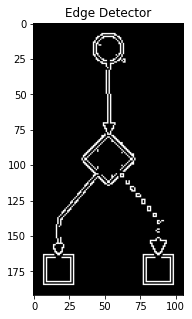

In [ ]:
# Edge Detector
t1 = 20
t2 = t1 * 3
edges = cv2.Canny(sharp, t1, t2)
# convert edges from image of (0s and 255s) to (0s and 1s).
normalizer = lambda x: int(x / 255)
edges = np.array([ [normalizer(rowCol) for rowCol in row] for row in edges])

# Display image
_, ax = plt.subplots(1, 1, figsize=figsize)
ax.imshow(edges, cmap='gray')
ax.set_title("Edge Detector")

In [ ]:
# Shape Detector
detect_shapes = True
detect_circles = True
detect_rectangles = True

threshold = 0.85 # a number between 0 and 1 (include edges)
significant_digits = 2
thickness = 10 # int bigger or equal to 2 ; How thick each kernel's shape will be

def getImgIndex(kernel_max_size):
    if kernel_max_size%2 == 0:
        return int((kernel_max_size/2)-1)
    else:
        return int((kernel_max_size-1)/2)

def overlapping_circles(center1, radius1, center2, radius2):
    y1, x1 = center1
    y2, x2 = center2
    # More understandable equation: (radius1 + (thickness/2)) + (radius2 + (thickness/2)) > norm([y1-y2, x1-x2])
    return radius1 + radius2 + thickness > norm([y1-y2, x1-x2])

def overlapping_rectangles(center1, width1, height1, center2, width2, height2):
    y1, x1 = center1
    y2, x2 = center2
    # More understandable equation: (height1/2 + thickness/2) + (height2/2 + thickness/2) > abs(y1 - y2) and (...)
    return (height1 + height2 > 2 * (abs(y1 - y2) -  thickness)) and (width1 + width2 > 2 * (abs(x1 - x2) - thickness))

def overlapping_rectangle_circle(center1, width1, height1, center2, radius2):
    y1, x1 = center1
    y2, x2 = center2
    width1 += thickness
    height1 += thickness
    radius2 += thickness
    
    distance_x_axis = abs(x1 - x2)
    distance_y_axis = abs(y1 - y2)
    half_width1 = width1/2
    half_height1 = height1/2

    if distance_x_axis > half_width1 + radius2:
        return False
    elif distance_y_axis > half_height1 + radius2:
        return False
    elif distance_x_axis <= half_width1:
        return True
    elif distance_y_axis <= half_height1:
        return True
    else:
        distance_corner = pow(distance_x_axis - half_width1, 2) + pow(distance_y_axis - half_height1, 2)
        return distance_corner <= pow(radius2, 2)

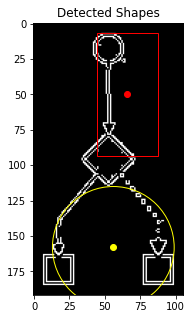

In [ ]:
# Initializing result arrays for circles
circles_center = []
circles_radius = []
circles_cover  = [] # Only used to compare between choosen shapes
# Note: we utilizing the fact that we iterate the radii from smallest to biggest
# thus, the inserted circles are always sorted by size. 

# Initializing result arrays for rectangles
rectangles_center = []
rectangles_width  = []
rectangles_height = []
rectangles_cover  = [] # Only used to compare between choosen shapes

# Note about comparing overlapping shapes: we prefer the bigger (area) shape.

y_max, x_max = img.shape
edges_pad = np.pad(edges, thickness, mode='constant', constant_values=0)

if detect_shapes:
    # Detecting Circles
    def insert_circle(center, radius, cover):
        to_be_remove = []
        
        for index in range(len(circles_center)):
            if overlapping_circles(center, radius, circles_center[index], circles_radius[index]):
                if round(cover, significant_digits) >= round(circles_cover[index], significant_digits):
                    # We found a circle that is worst than the current one
                    # Note: we also include equal here, we chose to remove because
                    # we iterate from smallest radius to biggest, and the current one
                    # will also be bigger or equal than those in circles_radius,
                    # so we prefer the bigger radius if possible.
                    to_be_remove.append(index)
                else:
                    # We found a circle better than the current one,
                    # no need to remove to_be_remove and no need to add current.
                    return
        
        for index in reversed(to_be_remove):
            del circles_center[index]
            del circles_radius[index]
            del circles_cover [index]
        
        circles_center.append(center)
        circles_radius.append(radius)
        circles_cover.append(cover)

    # Circle radius that will be checked
    radii = np.arange(int(math.ceil(thickness/2)), math.ceil(min(y_max,x_max) / 2), step=thickness + 1) if detect_circles else np.array([])
    length = radii.shape[0]

    for index in range(length):
        # Current radius
        radius = radii[index]

        # Creating all the circle's kernels according to the range of radius
        kernel_size = (2 * radius) + thickness
        kernel_center = int(round(kernel_size/2))
        kernel_off_set = (thickness%2) + 1
        kernel = cv2.circle(
                    np.zeros((kernel_size + kernel_off_set, kernel_size + kernel_off_set)),
                    (kernel_center, kernel_center),
                    radius,
                    color=1,
                    thickness=thickness)

        # Calculating the circumferences of each circle
        unique, counts = np.unique(kernel, return_counts=True)
        zero_one_dict = dict(zip(unique, counts))
        circumference = zero_one_dict[1] / thickness # This is approximation

        # Compute the accumulator for each possible radius
        hough = signal.convolve2d(edges_pad, kernel, mode='valid')

        # Seaching for circles in current hough
        y_dim,     x_dim     = hough.shape
        y_max_ker, x_max_ker = kernel.shape
        y_move = getImgIndex(y_max_ker) - thickness
        x_move = getImgIndex(x_max_ker) - thickness
        for y in range(y_dim):
            for x in range(x_dim):
                cover = min(1, hough[y][x] / circumference)
                if cover > threshold:
                    insert_circle((y_move+y, x_move+x), radius, cover)
    
    # Detecting Rectangles
    def insert_rectangle(center, width, height, cover):
        to_be_remove_circle    = []
        to_be_remove_rectangle = []

        for index in range(len(rectangles_center)):
            if overlapping_rectangles(center, width, height, rectangles_center[index], rectangles_width[index], rectangles_height[index]):
                if round(cover, significant_digits) >= round(rectangles_cover[index], significant_digits):
                    if (width + thickness) * (height + thickness) >= (rectangles_width[index] + thickness) * (rectangles_height[index] + thickness):
                        to_be_remove_rectangle.append(index)
                    else:
                        return
                else:
                    return
        
        for index in range(len(circles_center)):
            if overlapping_rectangle_circle(center, width, height, circles_center[index], circles_radius[index]):
                if round(cover, significant_digits) >= round(circles_cover[index], significant_digits):
                    # More understandable equation:
                    # (width + thickness) * (height + thickness) >= ((2 * circles_radius[index]) + thickness) * ((2 * circles_radius[index]) + thickness)
                    if (width + thickness) * (height + thickness) >= math.pi * pow((circles_radius[index] + (thickness/2)), 2):
                        to_be_remove_circle.append(index)
                    else:
                        return
                else:
                    return

        for index in reversed(to_be_remove_circle):
            del circles_center[index]
            del circles_radius[index]
            del circles_cover [index]
        
        for index in reversed(to_be_remove_rectangle):
            del rectangles_center[index]
            del rectangles_width [index]
            del rectangles_height[index]
            del rectangles_cover [index]
        
        rectangles_center.append(center)
        rectangles_width.append(width)
        rectangles_height.append(height)
        rectangles_cover.append(cover)
    
    # Rectangle width and height that will be checked
    widths  = np.arange((2 * int(math.ceil(thickness/2))) + 1, x_max, step=(thickness * 2) + 2) if detect_rectangles else np.array([])
    heights = np.arange((2 * int(math.ceil(thickness/2))) + 1, y_max, step=(thickness * 2) + 2) if detect_rectangles else np.array([])
    sizes = zipAll(widths, heights)
    length = len(sizes)

    for index in range(length):
        # Current width and height
        width, height = sizes[index]

        # Creating all the rectangle's kernels according to the range of width and height
        off_set = int(math.ceil(thickness/2))
        kernel = cv2.rectangle(
                    np.zeros((thickness + height + (thickness%2) + 1, thickness + width + (thickness%2) + 1)),
                    (off_set, off_set),
                    (off_set + width, off_set + height),
                    color=1,
                    thickness=thickness)

        # Calculating the circumferences of each circle
        unique, counts = np.unique(kernel, return_counts=True)
        zero_one_dict = dict(zip(unique, counts))
        circumference = zero_one_dict[1] / thickness # This is approximation

        # Compute the accumulator for each possible width/height
        hough = signal.convolve2d(edges_pad, kernel, mode='valid')

        # Seaching for rectangles in current hough
        y_dim,     x_dim     = hough.shape
        y_max_ker, x_max_ker = kernel.shape
        y_move = getImgIndex(y_max_ker) - thickness
        x_move = getImgIndex(x_max_ker) - thickness
        for y in range(y_dim):
            for x in range(x_dim):
                cover = min(1, hough[y][x] / circumference)
                if cover > threshold:
                    insert_rectangle((y_move+y, x_move+x), width, height, cover)

# Display image
_, ax = plt.subplots(1, 1, figsize=figsize)
ax.imshow(edges, cmap='gray')
ax.set_title("Detected Shapes")

if detect_shapes:
    # mark the center of the circles by a yellow point
    ax.plot([tpl[1] for tpl in circles_center], [tpl[0] for tpl in circles_center], 'o', color='yellow')
    # draw the circumference of the circles in blue
    for (y, x), radius in zip(circles_center, circles_radius):
        circ = plt.Circle((x, y), radius + (thickness/2), color='yellow', fill=False)
        ax.add_artist(circ)
    
    # mark the center of the rectangles by a red point
    ax.plot([tpl[1] for tpl in rectangles_center],[tpl[0] for tpl in rectangles_center], 'o', color='red')
    # draw the circumference of the rectangles in green
    for (y, x), width, height in zip(rectangles_center, rectangles_width, rectangles_height):
        dx = (width + thickness)/2
        dy = (height + thickness)/2
        rect = plt.Rectangle((x-dx, y-dy), width + thickness, height + thickness, 0.0, color='red', fill=False) # buttom-left, but look like top-left.
        ax.add_artist(rect)

In [ ]:
print("================================ Circles =================================")
for (y, x), radius, cover in zip(circles_center, circles_radius, circles_cover):
  print("Coordinate:",(y, x),"\t\tRadius:", radius, "\t\t\tCover:", cover)

print("=============================== Rectangles ===============================")
for (y, x), width, height, cover in zip(rectangles_center, rectangles_width, rectangles_height, rectangles_cover):
  print("Coordinate:",(y, x), "\t\tWidth:",width, "\tHeight:",height, "\tCover:", cover)

================================ Circles =================================
Coordinate: (158, 56) 		Radius: 38 			Cover: 1
=============================== Rectangles ===============================
Coordinate: (50, 66) 		Width: 33 	Height: 77 	Cover: 0.9957983193277311


Text(0.5, 1.0, 'Detected Shapes')

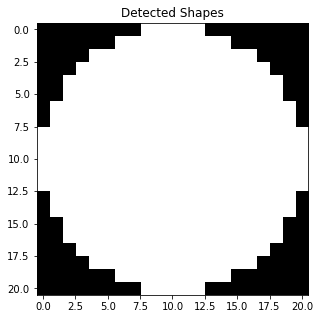

In [7]:
radius = 5
thickness = 10

kernel_size = (2 * radius) + thickness
kernel_center = int(round(kernel_size/2))
kernel_off_set = (thickness%2) + 1
kernel = cv2.circle(
            np.zeros((kernel_size + kernel_off_set, kernel_size + kernel_off_set)),
            (kernel_center, kernel_center),
            radius,
            color=1,
            thickness=thickness)

_, ax = plt.subplots(1, 1, figsize=figsize)
ax.imshow(kernel, cmap='gray')
ax.set_title("Detected Shapes")

In [ ]:
# Ideas:
# * Instead of making bigger and bigger kernels, we make the image smaller and smaller, and keep applying the same kernel.
# * Dynamic thickness depending on the size of the shape (atm I don't think it will help).

In [ ]:
y1 = 77
x1 = 100
width = 11
height = 11
cover1 = 0.8558558558558559

y2 = 99
x2 = 140
radius = 38
cover2 = 1

print(overlapping_rectangle_circle((y1, x1), width, height, (y2, x2), radius))
print(round(cover1, significant_digits) >= round(cover2, significant_digits))
print((width + thickness) * (height + thickness) >= math.pi * pow((radius + (thickness/2)), 2))

True
False
False
